In [1]:
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage
from mpl_toolkits.axes_grid1 import make_axes_locatable
import itertools
import matplotlib as mpl
import sys
import powerbox as pbox

from nbodykit.lab import *

from colossus.cosmology import cosmology
cosmo_c = cosmology.setCosmology('planck15')

In [2]:
def measure_autopk(array,L):
    mesh = ArrayMesh(array,BoxSize=L)
    r = FFTPower(mesh, mode='1d')
    return r.power

In [3]:
def noise(nc):
    # Build a unit-distribution of complex numbers with random phase
    a = np.random.normal(loc=0, scale=1, size=(nc,nc,nc))
    b = np.random.normal(loc=0, scale=1, size=(nc,nc,nc))
    return a + 1j * b

In [4]:
L=1000
nc=256
wn = noise(nc)
a = measure_autopk(wn,L)

[]

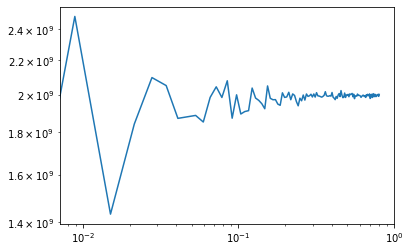

In [5]:
plt.plot(a['k'].real,a['power'].real)
plt.loglog()

In [6]:
k,p = np.loadtxt('Pk.input_zinit_normalized_at_z0.DAT',unpack=True)
p*=cosmo_c.growthFactor(100)*cosmo_c.growthFactor(100)

In [7]:
"""Create k^2 in box (nc x nc x nc)"""
def k_box(nc,L):
    kfac = 2.*np.pi/L
    k= np.fft.fftfreq(nc,d=1./nc/kfac) #d controls spacing
    a = np.transpose(np.indices((nc,nc,nc)).T, (2, 1, 0, 3)) #1 grid cell 3 coordinates
    k2=(k[a]**2).sum(axis=-1) # each grid cell is sum of squares of coordinates
    return (np.sqrt(k2))

In [8]:
kbox = k_box(nc,L)

In [9]:
np.random.seed(0)

In [10]:
def pk(kval):
    return np.interp(kval,k,p)
pb = pbox.PowerBox(N=nc,dim=3,pk=pk,boxlength=L)
wnpkbox = pb.delta_x()

/home/metin/anaconda3/lib/python3.8/site-packages/powerbox/dft.py:212: UserWarning: You do not have pyFFTW installed. Installing it should give some speed increase.
  warnings.warn("You do not have pyFFTW installed. Installing it should give some speed increase.")


In [11]:
Pk_box = np.interp(kbox,k,p)

In [12]:
wnpk = wn *np.sqrt(Pk_box/L**(3)*nc**(6))
               
a1 = np.fft.ifftn(wnpk)


In [13]:
b1 = measure_autopk(a1.real,L)
b3 = measure_autopk(wnpkbox.real,L)

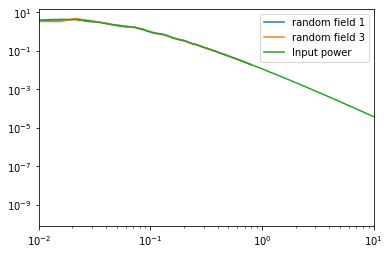

In [14]:
plt.plot(b1['k'].real,b1['power'].real,label="random field 1")
plt.plot(b3['k'].real,b3['power'].real,label="random field 3")

plt.plot(k,p,label="Input power")
plt.loglog()
plt.xlim(0.01,10)
#plt.ylim(1E-3,1E1)
plt.legend()

In [24]:
def plot_slice(a1):
    cmap = plt.get_cmap('jet')
    start = 64
    num=1
    end = 64+num
    c= a1[:,start:end,:].mean(axis=1)
    c = scipy.ndimage.interpolation.zoom(c ,order=1, zoom=2)

    fig = plt.figure(figsize=(12, 5))
    ax = fig.add_subplot(111)

    im = plt.imshow((c).T,interpolation='bilinear',origin='lower',aspect='auto',cmap=cmap)
    ax.set_aspect('equal')

    divider = make_axes_locatable(plt.gca())
    cax = divider.append_axes("right", "5%", pad="2%")
    cb = plt.colorbar(im,orientation='vertical',cax=cax)
    cb.ax.get_yaxis().labelpad = 0.
    plt.show()

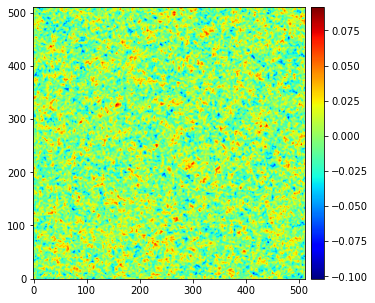

In [25]:
plot_slice(wnpkbox.real)

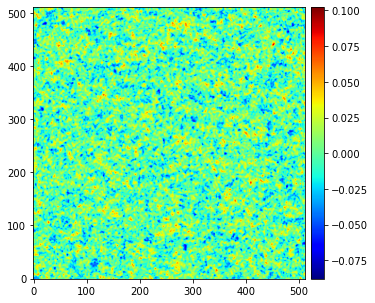

In [26]:
plot_slice(a1.real)